## LSTM training + correlation calc + hybrid eval

#### Importing training data

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
import rpy2.robjects as robjects

folder_name = '3_state_model'

data_log = pd.read_csv(folder_name + "/close_data_log.csv")

# Helper function to convert R data.frame to pandas DataFrame
def r_to_df(r_df):
    return pd.DataFrame({name: np.array(r_df.rx2(name)) for name in r_df.names})

# Read the RDS files using rpy2
readRDS = robjects.r['readRDS']

hmm_stats_r = readRDS(folder_name + "/hmm_stats_df.rds")
hmm_stats_df = r_to_df(hmm_stats_r)

hmm_state_losses = np.array(readRDS(folder_name + "/hmm_state_losses.rds"))
hmm_predictions = np.array(readRDS(folder_name + "/hmm_predictions.rds"))
hmm_ground_truth = np.array(readRDS(folder_name + "/hmm_ground_truth.rds"))
hmm_valid_loss = np.array(readRDS(folder_name + "/hmm_valid_loss.rds"))
hmm_transition_matrix = pd.read_csv(folder_name + "/transition_matrix.csv")

X_train = np.array(readRDS(folder_name + "/lstm_X_train.rds"))
Y_train = np.array(readRDS(folder_name + "/lstm_Y_train.rds"))
X_valid = np.array(readRDS(folder_name + "/lstm_X_valid.rds"))
Y_valid = np.array(readRDS(folder_name + "/lstm_Y_valid.rds"))
X_test = np.array(readRDS(folder_name + "/lstm_X_test.rds"))
Y_test = np.array(readRDS(folder_name + "/lstm_Y_test.rds"))

n_states = Y_train.shape[2]

### Define the model

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

lstm_units = 32
dense_units = 16
dropout_rate = 0.3
lookback = 5

# Compute Dirichlet parameters and predicted probabilities (for reference, not used in model)
def dirichlet_layer(evidence):
    alpha = evidence + 1
    S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
    probs = alpha / S
    return probs, alpha, S

# Custom evidential loss with annealing
class EvidentialLoss(tf.keras.losses.Loss):
    def __init__(self, annealing_rate=100.0, name='evidential_loss'):
        super().__init__(name=name)
        self.annealing_rate = tf.constant(annealing_rate, dtype=tf.float32)
        self.current_epoch = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    
    def call(self, y_true, evidence):
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
        probs = alpha / S
        err = tf.square(y_true - probs)
        var = probs * (1 - probs) / (S + 1)
        
        # Annealing factor for the regularization term
        lambda_ = tf.minimum(1.0, self.current_epoch / self.annealing_rate)
        
        return tf.reduce_mean(tf.reduce_sum(err + lambda_ * var, axis=-1))

# Custom callback to update the current epoch in the loss instance
class AnnealingCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if hasattr(self.model, 'loss') and isinstance(self.model.loss, EvidentialLoss):
            self.model.loss.current_epoch.assign(tf.cast(epoch, tf.float32))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def make_model():
    model = models.Sequential([
        layers.Input(shape=(lookback, X_train.shape[2])),  # Fixed shape (10, 20)
        
        # LSTM layer with added dropout
        layers.LSTM(lstm_units, dropout=dropout_rate),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        # Output raw evidence (non-negative)
        layers.Dense(n_states, activation='softplus')
    ])

    model.compile(
        loss=EvidentialLoss(annealing_rate=100.0),
        optimizer='adam',
        metrics=['accuracy']  # Accuracy on argmax(probs)
    )
    return model

### Train model for each forecast window

In [56]:
lookback = 5
max_horizon = 10

lstm_state_losses = np.full((len(Y_test), max_horizon), np.nan)
lstm_predictions = np.full((len(Y_test), max_horizon, n_states), np.nan)
lstm_ground_truth = np.full((len(Y_test), max_horizon, n_states), np.nan)
lstm_uncertainty = np.full((len(Y_test), max_horizon), np.nan)
last_state = np.full((len(Y_test), max_horizon, n_states), np.nan)
model_list = []

for forecast_horizon in range(0, max_horizon):

    # Clone the model architecture and set weights for each horizon
    model_h = make_model()

    history = model_h.fit(
        X_train[:, -lookback:, :],
        Y_train[:, forecast_horizon, :],
        epochs=25, callbacks=[AnnealingCallback(), early_stopping], verbose=0)
    
    model_list.append(model_h)
    Y_true = Y_test[:, forecast_horizon, :]

    Y_hat = model_h.predict(X_test[:, -lookback:, :])
    
    probs, alpha, S = dirichlet_layer(Y_hat)
    
    eps = 1e-15
    loss = -np.sum(Y_true * np.log(np.clip(probs, eps, 1.0)), axis=1)
    lstm_state_losses[0:len(loss), forecast_horizon] = loss
    lstm_predictions[0:len(loss), forecast_horizon, :] = probs
    lstm_ground_truth[0:len(loss), forecast_horizon, :] = Y_true
    last_state[0:len(loss), forecast_horizon, :] = X_test[:, -1, :n_states]
    lstm_uncertainty[0:len(loss), forecast_horizon] = S[:, 0]

/home/dcs01/.local/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### plotting results

In [57]:
# Compute statistics for each column of lstm_state_losses
stats = {
    'mean': np.nanmean(lstm_state_losses, axis=0),
    'median': np.nanmedian(lstm_state_losses, axis=0),
    'P25': np.nanpercentile(lstm_state_losses, 25, axis=0),
    'P75': np.nanpercentile(lstm_state_losses, 75, axis=0),
    'max': np.nanmax(lstm_state_losses, axis=0),
    'min': np.nanmin(lstm_state_losses, axis=0)
}

# Convert to DataFrame for better display
lstm_stats_df = pd.DataFrame(stats)
lstm_stats_df

,mean,median,P25,P75,max,min
0,0.716025,0.650922,0.496568,0.809159,3.114270,0.247345
1,0.774669,0.681593,0.530984,0.849679,2.996847,0.239562
2,0.808595,0.705152,0.650797,0.784111,3.313198,0.207854
3,0.809452,0.721893,0.623641,0.820884,3.329061,0.527779
4,0.881008,0.779121,0.728335,0.879027,2.736692,0.505076
5,0.847383,0.728984,0.683514,0.790558,3.167848,0.612798
6,0.874517,0.759886,0.714247,0.823573,3.003719,0.605861
7,0.872356,0.748001,0.715016,0.803380,3.147702,0.622558
8,0.839004,0.727098,0.699651,0.766197,3.359812,0.594014
9,0.858852,0.731540,0.713124,0.766440,3.633250,0.648010


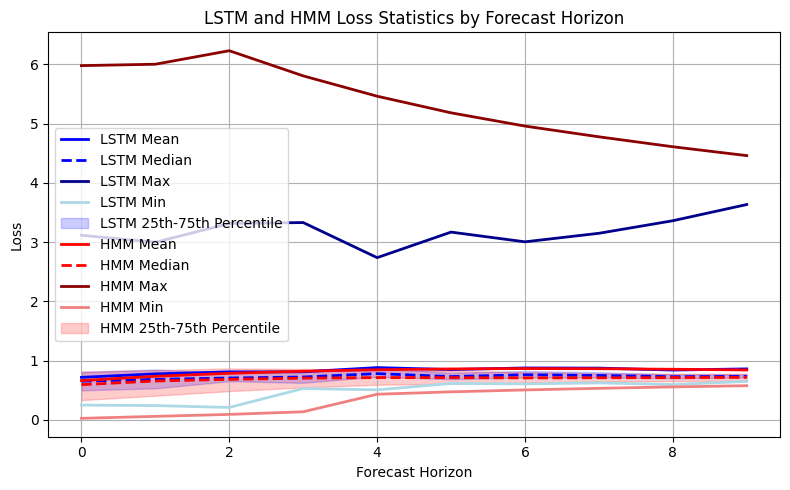

In [58]:
def plot_model_comparison(stats_df_1, stats_df_2, title_1, title_2, figsize=(8, 5)):

    fig, ax = plt.subplots(figsize=figsize)
    
    horizons = stats_df_1.index
    
    # Plot first model stats
    ax.plot(horizons, stats_df_1['mean'], label=f'{title_1} Mean', color='blue', linewidth=2)
    ax.plot(horizons, stats_df_1['median'], label=f'{title_1} Median', color='blue', linestyle='--', linewidth=2)
    ax.plot(horizons, stats_df_1['max'], label=f'{title_1} Max', color='darkblue', linewidth=2)
    ax.plot(horizons, stats_df_1['min'], label=f'{title_1} Min', color='lightblue', linewidth=2)
    ax.fill_between(horizons, stats_df_1['P25'], stats_df_1['P75'], color='blue', alpha=0.2, label=f'{title_1} 25th-75th Percentile')
    
    # Plot second model stats
    ax.plot(horizons, stats_df_2['mean'], label=f'{title_2} Mean', color='red', linewidth=2)
    ax.plot(horizons, stats_df_2['median'], label=f'{title_2} Median', color='red', linestyle='--', linewidth=2)
    ax.plot(horizons, stats_df_2['max'], label=f'{title_2} Max', color='darkred', linewidth=2)
    ax.plot(horizons, stats_df_2['min'], label=f'{title_2} Min', color='lightcoral', linewidth=2)
    ax.fill_between(horizons, stats_df_2['P25'], stats_df_2['P75'], color='red', alpha=0.2, label=f'{title_2} 25th-75th Percentile')
    
    ax.set_xlabel('Forecast Horizon')
    ax.set_ylabel('Loss')
    ax.set_title(f'{title_1} and {title_2} Loss Statistics by Forecast Horizon')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Use the function
plot_model_comparison(lstm_stats_df, hmm_stats_df, 'LSTM', 'HMM')

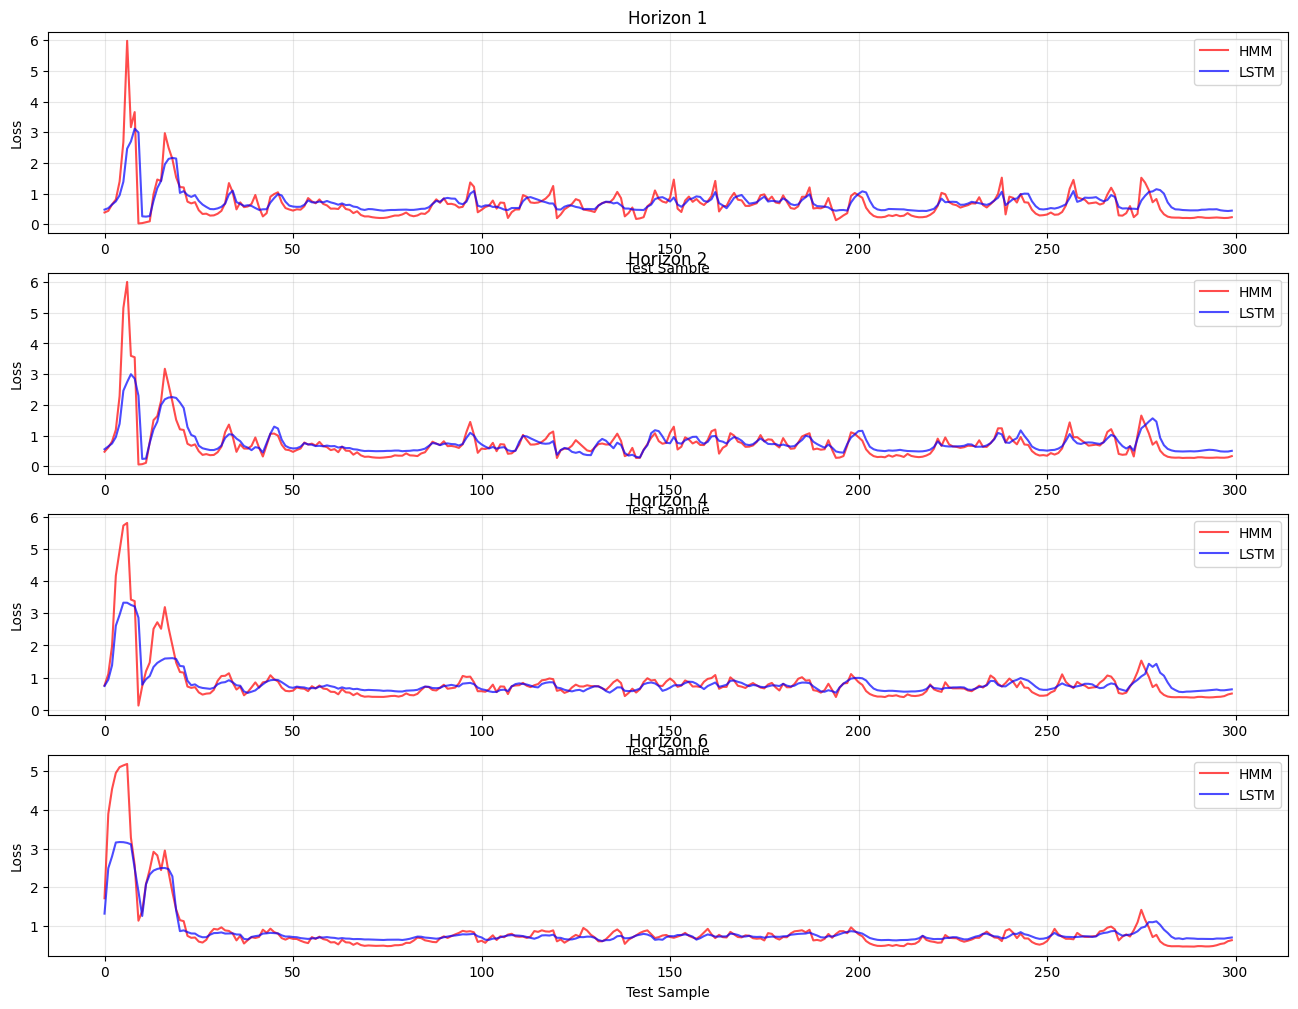

In [59]:
plt.figure(figsize=(16, 12))

# Horizon indices (0-based): 0, 1, 3
horizons = [0, 1, 3, 5]
titles = ['Horizon 1', 'Horizon 2', 'Horizon 4', 'Horizon 6']

for i, horizon in enumerate(horizons):
    ax = plt.subplot(4, 1, i + 1)
    ax.plot(hmm_state_losses[:, horizon], label='HMM', color='red', alpha=0.7)
    ax.plot(lstm_state_losses[:, horizon], label='LSTM', color='blue', alpha=0.7)
    ax.set_title(titles[i])
    ax.set_xlabel('Test Sample')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

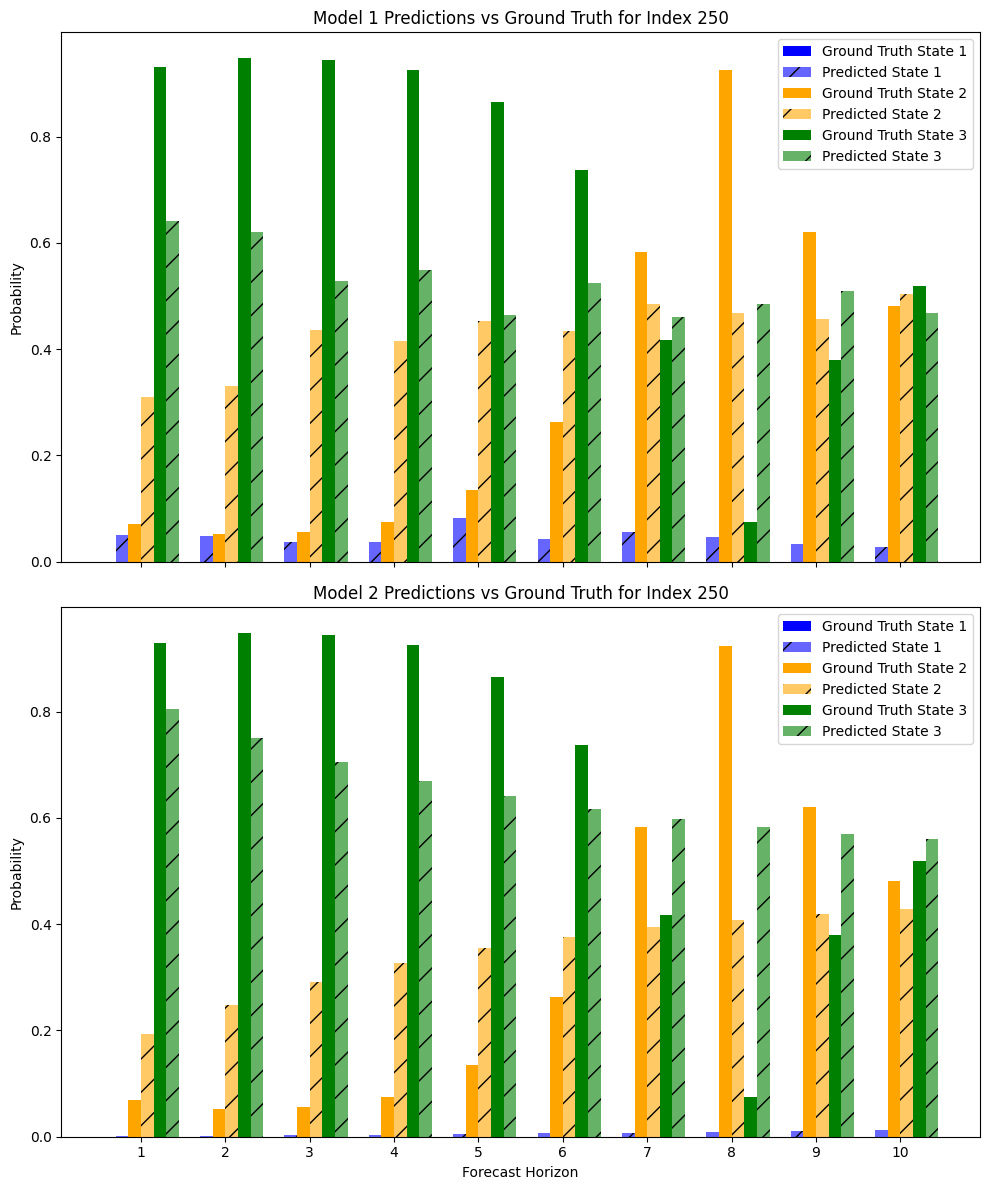

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison_bars(model_1_predictions, model_2_predictions, ground_truth, index):
    # Assuming lstm_predictions, lstm_ground_truth, hmm_predictions, and hmm_ground_truth are defined as 3D arrays (e.g., shape: samples, horizons, states)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    forecast_range = np.arange(model_1_predictions.shape[1])
    bar_width = 0.15
    # Plot for Model 1 on ax1
    for state, color in zip(range(n_states), ['blue', 'orange', 'green']):
        offset = state * (bar_width * 2)
        # Plot ground truth (solid, opaque)
        ax1.bar(
            forecast_range + offset,
            ground_truth[index, :, state],
            width=bar_width,
            label=f'Ground Truth State {state+1}',
            color=color,
            alpha=1
        )
        # Plot predictions (with striped pattern for distinction)
        ax1.bar(
            forecast_range + offset + bar_width,
            model_1_predictions[index, :, state],
            width=bar_width,
            label=f'Predicted State {state+1}',
            color=color,
            alpha=0.6,
            hatch='/'
        )

    # Avoid duplicate labels in legend for ax1
    handles1, labels1 = ax1.get_legend_handles_labels()
    unique1 = dict(zip(labels1, handles1))
    ax1.legend(unique1.values(), unique1.keys())
    ax1.set_ylabel('Probability')
    ax1.set_title(f'Model 1 Predictions vs Ground Truth for Index {index}')

    # Plot for Model 2 on ax2
    for state, color in zip(range(n_states), ['blue', 'orange', 'green']):
        offset = state * (bar_width * 2)
        # Plot ground truth (solid, opaque)
        ax2.bar(
            forecast_range + offset,
            ground_truth[index, :, state],
            width=bar_width,
            label=f'Ground Truth State {state+1}',
            color=color,
            alpha=1
        )
        # Plot predictions (with striped pattern for distinction)
        ax2.bar(
            forecast_range + offset + bar_width,
            model_2_predictions[index, :, state],
            width=bar_width,
            label=f'Predicted State {state+1}',
            color=color,
            alpha=0.6,
            hatch='/'
        )

    # Avoid duplicate labels in legend for ax2
    handles2, labels2 = ax2.get_legend_handles_labels()
    unique2 = dict(zip(labels2, handles2))
    ax2.legend(unique2.values(), unique2.keys())
    ax2.set_xlabel('Forecast Horizon')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Model 2 Predictions vs Ground Truth for Index {index}')

    # Set x-ticks centered for each group
    xtick_positions = forecast_range + bar_width * 2.5
    ax2.set_xticks(xtick_positions)
    ax2.set_xticklabels([str(i+1) for i in forecast_range])

    plt.tight_layout()
    plt.show()

plot_comparison_bars(lstm_predictions, hmm_predictions, lstm_ground_truth, index=250)

### Get uncertainty metrics

In [61]:
# Define the mc_dropout_predictions function
def mc_dropout_predictions(model, X, Y_true=None, num_samples=1000):
    
    predictions = np.stack([model(X, training=True) for _ in range(num_samples)], axis=0)
    probs, alpha, S = dirichlet_layer(predictions)
    num_examples, num_classes = probs.shape[1], probs.shape[2]
    mean_probs = np.mean(probs, axis=0)
    mean_S = np.mean(S, axis=0)
    std_S = np.std(S, axis=0)
    epsilon = 1e-10
    entropy = -np.sum(mean_probs * np.log(mean_probs + epsilon), axis=1, keepdims=True)
    std_dev = np.std(probs, axis=0)
    mean_std_dev = np.mean(std_dev, axis=1, keepdims=True)
    max_std_dev = np.max(std_dev, axis=1, keepdims=True)
    per_sample_loss = np.zeros((num_examples, 1))
    if Y_true is not None:
        Y_true = np.asarray(Y_true)
        cross_entropy = -np.sum(Y_true * np.log(mean_probs + epsilon), axis=1, keepdims=True)
        per_sample_loss = cross_entropy
    df = pd.DataFrame()

    df[[f'Class_{i}_True' for i in range(num_classes)]] = Y_true
    df[[f'Class_{i}_Prob' for i in range(num_classes)]] = mean_probs
    df['Predictive_Entropy'] = entropy
    for i in range(num_classes):
        df[f'Class_{i}_StdDev'] = std_dev[:, i]
    df['Mean_StdDev'] = mean_std_dev
    df['Max_StdDev'] = max_std_dev
    df['Per_Sample_Loss'] = per_sample_loss
    df['Per_sample_uncertainty_mean'] = mean_S
    df['Per_sample_uncertainty_std'] = std_S
    if len(X) == hmm_state_losses.shape[0]:
        df['hmm_loss'] = hmm_state_losses[:, forecast_horizon]
    elif len(X) == hmm_valid_loss.shape[0]:
        df['hmm_loss'] = hmm_valid_loss[:, forecast_horizon]
    else:
        df['hmm_loss'] = np.zeros((len(X),))
    df['loss_difference'] = df['Per_Sample_Loss'] - df['hmm_loss']

    return df

In [62]:
uncertainty_dfs = []
for i, model in enumerate(model_list):
    uncertainty_df = mc_dropout_predictions(model, X_valid, Y_valid[:, i, :], num_samples=100)
    uncertainty_dfs.append(uncertainty_df)

In [63]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Loop over all dfs and construct results dataframe
results = []
reg_models = []
for i, df in enumerate(uncertainty_dfs):
    corr = df[['loss_difference', 'Predictive_Entropy', 'Mean_StdDev', 'Max_StdDev', 'Per_sample_uncertainty_mean']].corr()[['loss_difference']]
    X = df[['Predictive_Entropy', 'Mean_StdDev', 'Per_sample_uncertainty_mean', 'Per_sample_uncertainty_std']].values
    y = df['loss_difference'].values
    
    reg = LinearRegression().fit(X, y)
    r_sq = reg.score(X, y)
    mult_corr = np.sqrt(r_sq)

    reg_models.append(reg)
    
    results.append({
        'horizon': i,
        'Predictive_Entropy': corr.loc['Predictive_Entropy', 'loss_difference'],
        'Mean_StdDev': corr.loc['Mean_StdDev', 'loss_difference'],
        'Max_StdDev': corr.loc['Max_StdDev', 'loss_difference'],
        'Per_sample_uncertainty_mean': corr.loc['Per_sample_uncertainty_mean', 'loss_difference'],
        'multiple_correlation': mult_corr
    })

correlation = pd.DataFrame(results)
correlation

,horizon,Predictive_Entropy,Mean_StdDev,Max_StdDev,Per_sample_uncertainty_mean,multiple_correlation
0,0,0.366795,0.075864,0.061182,0.138516,0.379325
1,1,-0.081251,0.294684,0.268519,-0.385755,0.386914
2,2,0.038625,0.271778,0.267601,-0.185313,0.311294
3,3,0.349473,0.128234,-0.011905,-0.253443,0.387603
4,4,-0.262836,-0.025230,-0.148110,0.143073,0.303293
5,5,0.344454,0.377742,0.213001,-0.305469,0.448649
6,6,0.270087,0.124115,0.018697,-0.328750,0.350373
7,7,0.035482,0.015694,-0.039363,-0.084019,0.105317
8,8,0.349119,0.321524,0.299627,-0.377851,0.411636
9,9,0.079959,0.009542,-0.009491,-0.102344,0.186458


In [64]:
test_uncertainty_dfs = []
for i, model in enumerate(model_list):
    test_uncertainty_df = mc_dropout_predictions(model, X_test, Y_test[:, i, :], num_samples=100)
    test_uncertainty_dfs.append(test_uncertainty_df)

certainty_scores = []
for i, df in enumerate(test_uncertainty_dfs):
    reg = reg_models[i]
    X = df[['Predictive_Entropy', 'Mean_StdDev', 'Per_sample_uncertainty_mean', 'Per_sample_uncertainty_std']].values
    score = reg.predict(X)
    certainty_scores.append(score)  # Negate to get certainty score


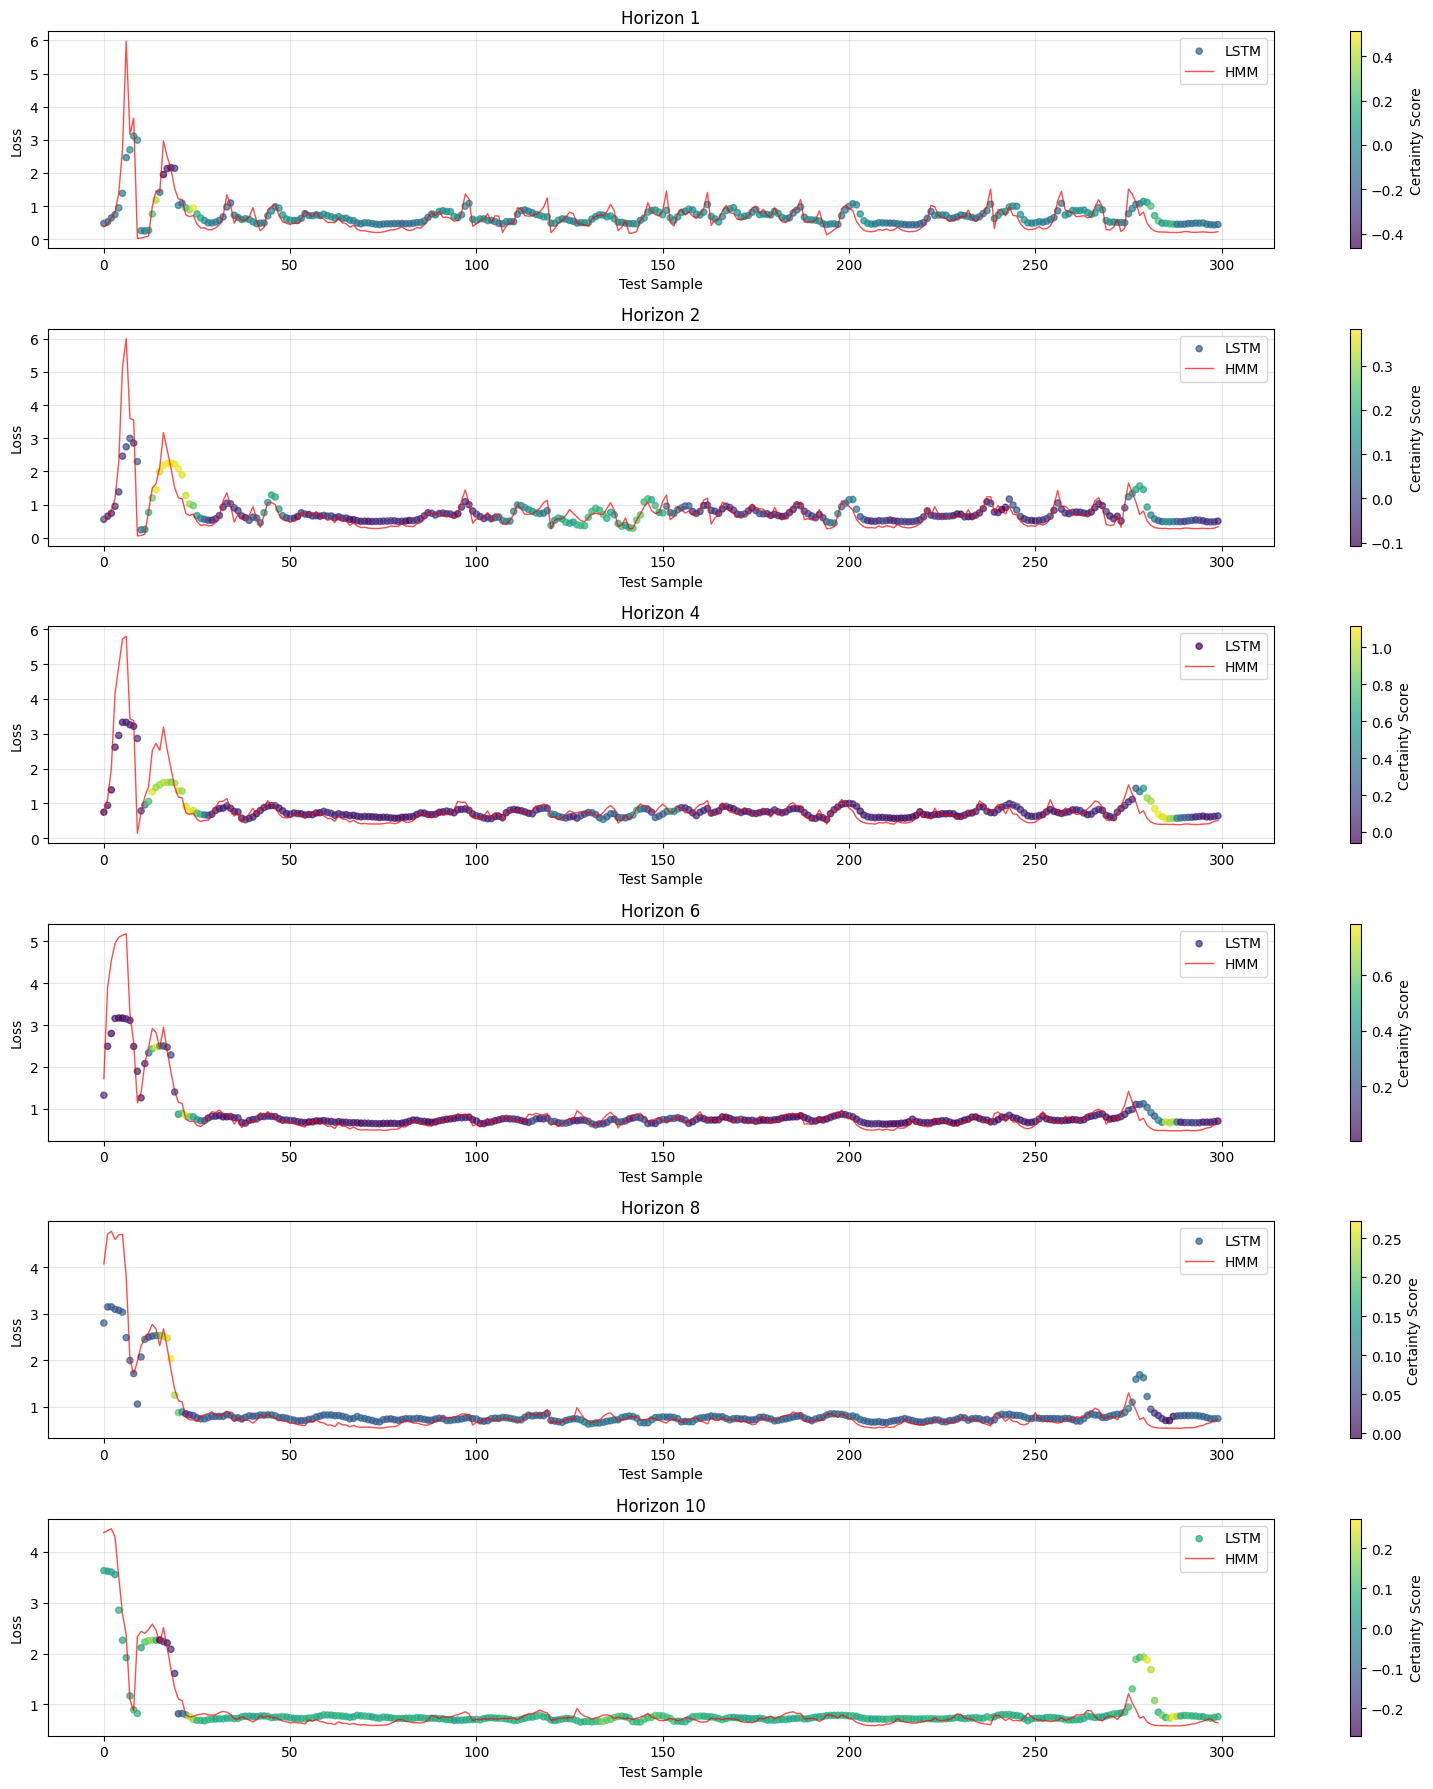

In [65]:
# Horizon indices (0-based): 0, 1, 3
horizons = [0, 1, 3, 5, 7, 9]
titles = ['Horizon 1', 'Horizon 2', 'Horizon 4', 'Horizon 6', 'Horizon 8', 'Horizon 10']

plt.figure(figsize=(16, 18))

for i, horizon in enumerate(horizons):
    ax = plt.subplot(6, 1, i + 1)
    
    # Create scatter plot for LSTM colored by certainty scores
    scatter = ax.scatter(range(len(lstm_state_losses[:, horizon])), 
                        lstm_state_losses[:, horizon], 
                        c=certainty_scores[horizon], 
                        cmap='viridis', 
                        label='LSTM', 
                        alpha=0.7, 
                        s=20)
    
    # Plot HMM losses
    ax.plot(hmm_state_losses[:, horizon], 
           label='HMM', 
           color='red', 
           alpha=0.7, 
           linewidth=1)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Certainty Score')
    
    ax.set_title(titles[i])
    ax.set_xlabel('Test Sample')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Plot Hybrid model

In [83]:
transition_matrix = hmm_transition_matrix.drop(columns=['Unnamed: 0'])
transition_matrix = transition_matrix.rename(columns={'state.1.1': 0, 'state.2.1': 1, 'state.3.1': 2})

alpha = 0.3
trials = lstm_predictions.shape[0]
horizons = lstm_predictions.shape[1]
combined_transitions = np.zeros((trials, horizons, n_states, n_states))
for trial in range(trials):
    for horizon in range(horizons):
        #_alpha = (alpha + 0) / (horizon + 0 + 1)
        combined = np.tile(lstm_predictions[trial, horizon, :], (n_states, 1)) * alpha + transition_matrix * (1 - alpha)
        combined_transitions[trial, horizon, :, :] = combined

hybrid_predictions = np.zeros((trials, horizons, n_states))
for trial in range(trials):
    for horizon in range(horizons):
        if horizon == 0:
            last_prediction = last_state[trial, 0, :]
        else:
            last_prediction = hybrid_predictions[trial, horizon - 1, :]
        next_prediction = last_prediction @ combined_transitions[trial, horizon, :, :]
        hybrid_predictions[trial, horizon, :] = next_prediction

hybrid_state_loss = -np.sum(
    lstm_ground_truth * np.log(np.clip(hybrid_predictions, eps, 1.0)),
    axis=2
) 

In [84]:
# Compute statistics for each column of lstm_state_losses
stats = {
    'mean': np.nanmean(hybrid_state_loss, axis=0),
    'median': np.nanmedian(hybrid_state_loss, axis=0),
    'P25': np.nanpercentile(hybrid_state_loss, 25, axis=0),
    'P75': np.nanpercentile(hybrid_state_loss, 75, axis=0),
    'max': np.nanmax(hybrid_state_loss, axis=0),
    'min': np.nanmin(hybrid_state_loss, axis=0)
}

# Convert to DataFrame for better display
hybrid_stats_df = pd.DataFrame(stats)
hybrid_stats_df

,mean,median,P25,P75,max,min
0,0.655724,0.595489,0.378567,0.779555,3.460262,0.096010
1,0.729578,0.662834,0.479152,0.810523,3.313471,0.160235
2,0.777088,0.698828,0.571301,0.815890,3.540872,0.203819
3,0.801823,0.714700,0.619860,0.809681,3.455235,0.533102
4,0.830999,0.732410,0.659194,0.817701,3.036752,0.567539
5,0.840200,0.734649,0.677542,0.802892,3.066186,0.602740
6,0.851665,0.741067,0.701772,0.789529,3.020412,0.624069
7,0.854560,0.743247,0.714641,0.787372,3.049511,0.653148
8,0.844447,0.740223,0.712520,0.774592,3.121620,0.661316
9,0.840053,0.736877,0.720415,0.761267,3.235770,0.674673


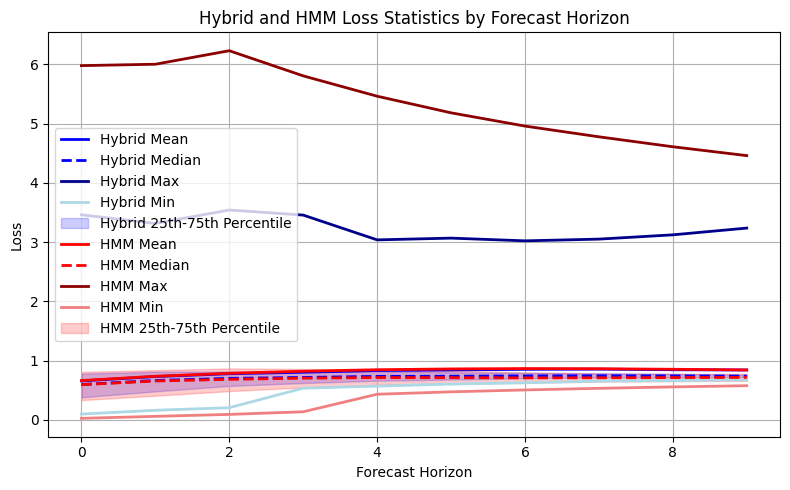

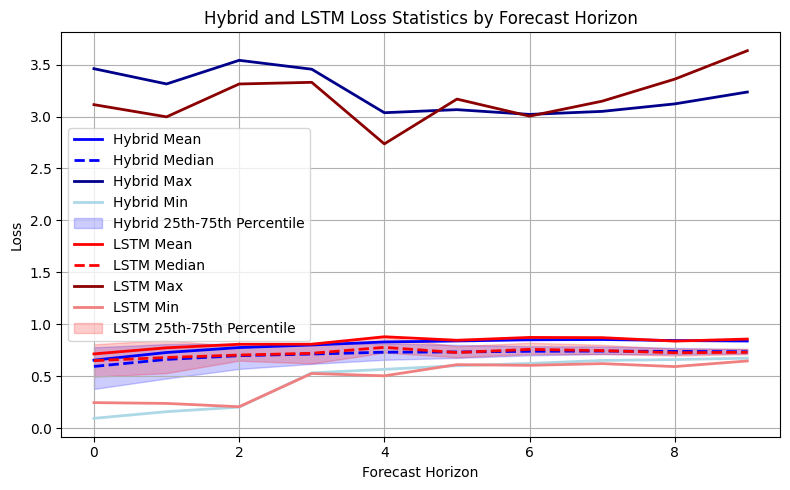

In [88]:
plot_model_comparison(hybrid_stats_df, hmm_stats_df, 'Hybrid', 'HMM')
plot_model_comparison(hybrid_stats_df, lstm_stats_df, 'Hybrid', 'LSTM')

In [86]:
hybrid_stats_df - hmm_stats_df

,Horizon,P25,P75,max,mean,median,min
0,NaN,0.046616,-0.029612,-2.517737,-0.005923,0.002805,0.071855
1,NaN,0.073356,-0.026548,-2.688186,-0.004649,0.008687,0.102448
2,NaN,0.087620,-0.050414,-2.688872,-0.007531,0.016824,0.113203
3,NaN,0.074359,-0.048010,-2.349895,-0.017546,0.012511,0.398249
4,NaN,0.068464,-0.023577,-2.425167,-0.013701,0.019982,0.136314
5,NaN,0.068947,-0.023080,-2.115197,-0.018017,0.023629,0.131374
6,NaN,0.076502,-0.011527,-1.937146,-0.012777,0.033835,0.120618
7,NaN,0.070459,0.006605,-1.726935,-0.006992,0.034653,0.122207
8,NaN,0.060054,-0.001511,-1.486922,-0.008153,0.028160,0.106384
9,NaN,0.062568,-0.014352,-1.223243,-0.001036,0.021693,0.099487


In [87]:
hybrid_stats_df - lstm_stats_df

,mean,median,P25,P75,max,min
0,-0.060300,-0.055433,-0.118001,-0.029604,0.345992,-0.151335
1,-0.045091,-0.018759,-0.051832,-0.039156,0.316625,-0.079327
2,-0.031507,-0.006324,-0.079496,0.031779,0.227674,-0.004035
3,-0.007629,-0.007193,-0.003781,-0.011203,0.126174,0.005323
4,-0.050009,-0.046711,-0.069141,-0.061326,0.300060,0.062463
5,-0.007183,0.005664,-0.005971,0.012333,-0.101662,-0.010059
6,-0.022852,-0.018819,-0.012475,-0.034044,0.016693,0.018209
7,-0.017796,-0.004754,-0.000375,-0.016007,-0.098191,0.030591
8,0.005444,0.013125,0.012869,0.008395,-0.238192,0.067302
9,-0.018799,0.005337,0.007291,-0.005173,-0.397480,0.026663
